# Logistic Regression

En éste notebook vamos a ver la implementación en NumPy del modelo de regresión logística mediante gradient descent, usando los resultados obtenidos de la teoría. Por último, se computarán las métricas para medir el rendimiento del modelo.

## Cargamos las Librerías

In [4]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [11]:
import sys  
sys.path.insert(0, r'C:\Users\Agustin\Documents\RepositorioCEIA_Git\Carrera-de-Especializacion-en-IA\B2-Artificial_Inteligence\Clase_3\ejercicios\src')

In [12]:
from models import BaseModel

In [13]:
from metrics import Accuracy, Precision, Recall

## Cargamos el Dataset

In [16]:
class Data(object):

    def __init__(self, path):
        self.dataset = self._build_dataset(path)

    def _build_dataset(self, path):
        structure = [('x_1', float),
                     ('x_2', float),
                     ('y', float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]), float(line.split(',')[2]))
                        for i, line in enumerate(data_csv) if i != 0)
            embeddings = np.fromiter(data_gen, structure)

        return embeddings

    def split(self, percentage):
        X = np.array([self.dataset['x_1'], self.dataset['x_2']]).T
        y = self.dataset['y']

        permuted_idxs = np.random.permutation(X.shape[0])

        train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]

        test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test

In [17]:
dataset = Data('data/clase_6_dataset.txt')
X_train, X_test, y_train, y_test = dataset.split(0.8)

print('Formato del dataset: {}'.format(X_train.shape))

Formato del dataset: (79, 2)


In [18]:
X_test.shape

(20, 2)

In [19]:
print(X_test[:10, :])

[[49.07256322 51.88321182]
 [94.09433113 77.15910509]
 [88.91389642 69.8037889 ]
 [94.83450672 45.6943068 ]
 [62.0730638  96.76882412]
 [77.19303493 70.4582    ]
 [76.97878373 47.57596365]
 [75.01365839 30.60326323]
 [95.86155507 38.22527806]
 [64.03932042 78.03168802]]


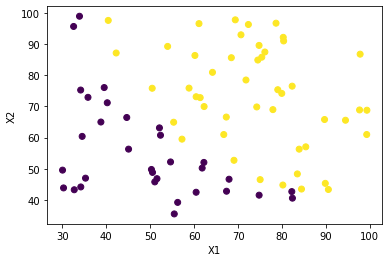

In [20]:
# Observamos los datos
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [21]:
# escalamos los datos de entrada.Es importante para evitar poblemas numéricos como overflow.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
X_train[:5, :]

array([[ 0.29388285,  1.73829003],
       [ 1.38439654, -1.14102191],
       [ 0.4233669 ,  0.67889573],
       [-0.6547687 , -1.05864615],
       [-0.70870183, -0.94869198]])

In [23]:
X_test[:5, :]

array([[-0.78655738, -0.78221448],
       [ 1.61060741,  0.60771321],
       [ 1.33477738,  0.20324253],
       [ 1.65001774, -1.12254391],
       [-0.09435128,  1.68605656]])

## Regresión Logística

In [24]:
class LogisticRegression(BaseModel):
    
    # definimos la función sigmoid para entrenamiento y las predicciones
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # definimos la función loss para reportarla cada cierta cantidad de epochs
    def loss(self, y, y_hat):
        loss = np.mean(-y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
        return loss 

    def fit(self, X, y, lr, b, epochs, bias=True, log=100, verbose=True):

        # si decidimos utilizar bias, agregamos como siempre una columna con '1' al dataset de entrada
        if bias:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        # inicializamos aleatoriamente los pesos
        m = X.shape[1]
        W = np.random.randn(m).reshape(m, 1)

        loss_list = []
        
        # corremos Mini-Batch para optimizar los parámetros
        for j in range(epochs):
            idx = np.random.permutation(X.shape[0])
            X_train = X[idx]
            y_train = y[idx]
            batch_size = int(len(X_train) / b)

            for i in range(0, len(X_train), batch_size):
                end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
                batch_X = X_train[i: end]
                batch_y = y_train[i: end]

                prediction = self.sigmoid(np.sum(np.transpose(W) * batch_X, axis=1))
                error = prediction.reshape(-1, 1) - batch_y.reshape(-1, 1)
                grad_sum = np.sum(error * batch_X, axis=0)
                grad_mul = 1 / batch_size * grad_sum
                gradient = np.transpose(grad_mul).reshape(-1, 1)

                W = W - (lr * gradient)
            
            l_epoch = self.loss(y_train, self.sigmoid(np.dot(X_train, W)))
            loss_list.append(l_epoch)
            if verbose:
                if j%log==0:
                    print("Epoch: {}, Loss: {}".format(j, l_epoch))
                
        self.model = W
        self.losses = loss_list

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        p = self.sigmoid(X @ self.model)
        mask_true = p >= 0.5
        mask_false = p < 0.5
        p[mask_true] = 1
        p[mask_false] = 0
        return p

In [29]:
# Seleccionar hiperparámetros
lr = 0.01
b = 16
epochs = 1000
bias = True

# Hacer el fit del modelo con los HPs seleccionados
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train.reshape(-1, 1), lr, b, epochs, bias, log=50)
print("\nModelo de regresion logistica:\n",logistic_regression.model)
predictions = logistic_regression.predict(X_test)

Epoch: 0, Loss: 0.6277896692605964
Epoch: 50, Loss: 0.2773425285044928
Epoch: 100, Loss: 0.23092286521616356
Epoch: 150, Loss: 0.21044161126251912
Epoch: 200, Loss: 0.19840979607396095
Epoch: 250, Loss: 0.19039064844693143
Epoch: 300, Loss: 0.18464334264637988
Epoch: 350, Loss: 0.18031952484135785
Epoch: 400, Loss: 0.1769531623428482
Epoch: 450, Loss: 0.17426377345451025
Epoch: 500, Loss: 0.17207146430314132
Epoch: 550, Loss: 0.17025571237221615
Epoch: 600, Loss: 0.1687317707934755
Epoch: 650, Loss: 0.16743887552058032
Epoch: 700, Loss: 0.1663311363611055
Epoch: 750, Loss: 0.16537508535167075
Epoch: 800, Loss: 0.164543739090691
Epoch: 850, Loss: 0.1638164895985687
Epoch: 900, Loss: 0.16317708075365264
Epoch: 950, Loss: 0.16261212775542272

Modelo de regresion logistica:
 [[1.50221376]
 [4.20254029]
 [3.40031798]]


### Decision Boundary

En los casos donde tengamos dos o tres features en el dataset, podemos graficar la línea de decisión (plano para 3 features) que aplica el modelo para clasificar las muestras bajo una u otra clase. La derivación surge de la fórmula lineal que se utiliza en la sigmoid:

$\hat{y}\geq 0.5 \to 1$ 

$\hat{y}<0.5 \to 0$

Teniendo en cuenta la función sigmoid:

$\hat{y}\geq 0.5 \Leftrightarrow w.x + b \geq 0$

Por lo que la decision boundary es:

$w.x + b \geq 0$


Igualando a la ecuación de una recta en 2D, donde la abcisa es $X_1$ y la ordenada $X_2$:

$w_1x_1 + w_2x_2 + w_0 = mx_1 + c$

$w_1x_1 + w_2x_2 + w_0 = 0 $

$w_1x_1 + w_2mx_1+w_2c + w_0 = 0$

$x_1 = 0 \to w_2c + w_0 = 0$ 

$c = -w_0/w_2$

Reemplazando $c$:

$w_1x_1 + w_2mx_1 = 0$

$w_1x_1 = -w_2mx_1$

$m = -w_1/w_2$

In [24]:
# Calculamos el slope e intercept para graficar
slope = -(logistic_regression.model[1] / logistic_regression.model[2])
intercept = -(logistic_regression.model[0] / logistic_regression.model[2])

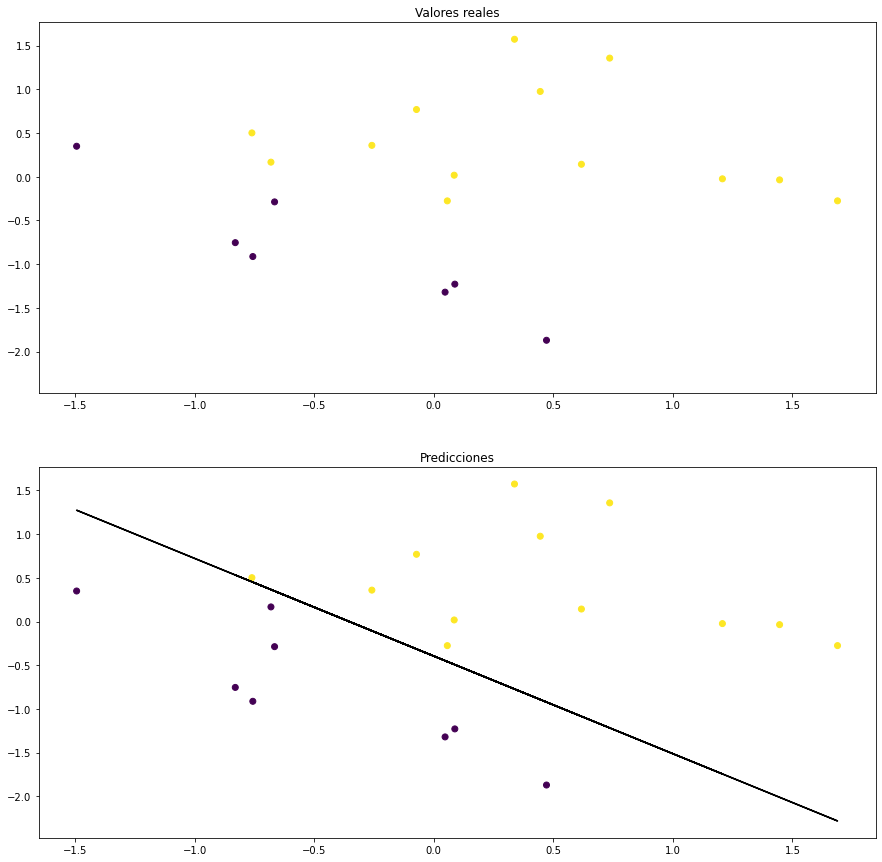

In [25]:
# Graficos
f, (ax, bx) = plt.subplots(2, 1, sharey='col', figsize=(15, 15))

ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
ax.set_title('Valores reales')

bx.scatter(X_test[:, 0], X_test[:, 1], c=predictions[:, 0])
y_vals = intercept + (slope * X_test[:, 0])
bx.plot(X_test[:, 0], y_vals, c="k")
bx.set_title('Predicciones')

plt.show()

### Calculamos las métricas

In [26]:
predictions.shape

(20, 1)

In [27]:
metrics = [Accuracy(), Precision(), Recall()]
results = {}
for metric in metrics:
    name = metric.__class__.__name__
    results[name] = metric(y_test, predictions[:, 0])
    print('{metric}: {value}'.format(metric=name, value=results[name]))

Accuracy: 0.95
Precision: 1.0
Recall: 0.9230769230769231


### K-folds para selección de hiperparámetros

In [37]:
def k_folds(X_train, y_train, lr, b, epochs, bias=True, k=5, verbose=False):
    
    # Definimos el modelo a emplear
    l_regression = LogisticRegression()

    # Definimos una métrica
    error = Accuracy()

    chunk_size = int(len(X_train) / k)
    acc_list = []

    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        l_regression.fit(new_X_train, new_y_train, lr, b, epochs, bias, verbose=verbose)
        prediction = l_regression.predict(new_X_valid)
        k_error = error(new_y_valid, prediction)
        acc_list.append(k_error)
        # print("Modelo {i} de {k}, Métrica: {error}".format(i=i/chunk_size, k=k, error=k_error))
        
    mean_acc = np.mean(acc_list)

    return mean_acc

In [38]:
# K-Folds para determinación del learning rate

lr_list = np.linspace(0.001, 0.01, 10)
kfolds_lr = np.zeros(lr_list.shape)

for i, lr in enumerate(lr_list):
    kfolds_lr[i] = k_folds(X_train, y_train.reshape(-1, 1), lr, 16, 1000)

best_lr = lr_list[np.argmax(kfolds_lr)]

In [39]:
best_lr

0.007

In [42]:
colname = ['learning_rate', 'kfolds_mean']
lr_df = pd.DataFrame(np.column_stack([lr_list, kfolds_lr]),columns=colname)

In [45]:
lr_df.head(2)

,learning_rate,kfolds_mean
0,0.001,0.836111
1,0.002,0.836111


In [46]:
lr_df.describe()

,learning_rate,kfolds_mean
count,10.000000,10.000000
mean,0.005500,0.840556
std,0.003028,0.005738
min,0.001000,0.836111
25%,0.003250,0.836111
50%,0.005500,0.836111
75%,0.007750,0.847222
max,0.010000,0.847222


In [47]:
# K-Folds para determinación del batch
batch_list = np.linspace(1, 30, 30)
kfolds_b = np.zeros(batch_list.shape)

for i, b in enumerate(batch_list):
    kfolds_b[i] = k_folds(X_train, y_train.reshape(-1, 1), best_lr, b, 1000)

best_b = batch_list[np.argmax(kfolds_b)]

In [48]:
best_b

13.0

In [49]:
colname = ['batch', 'kfolds_mean']
batch_df = pd.DataFrame(np.column_stack([batch_list, kfolds_b]),columns=colname)

In [51]:
batch_df.describe()

,batch,kfolds_mean
count,30.000000,30.000000
mean,15.500000,0.842778
std,8.803408,0.005536
min,1.000000,0.836111
25%,8.250000,0.836111
50%,15.500000,0.847222
75%,22.750000,0.847222
max,30.000000,0.847222
